<a href="https://colab.research.google.com/github/mc-ivan/proyecto-teoria-juegos/blob/main/notebook/Proyecto_Teoria_Juegos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

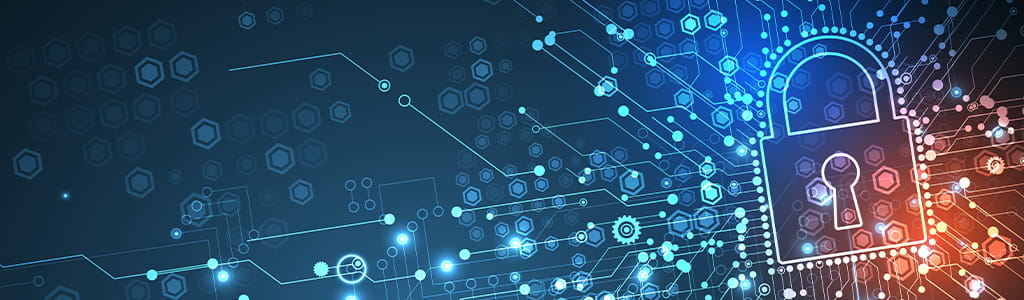

# Competencia Estratégica en Streaming con Estimación de Pagos y Equilibrios de Nash en un Diseño 2×3×2

## Integrantes:
- Gimena Javier
- Giovanni Ortiz
- Ivan Mamani
---

In [88]:
# Librerias
#!pip -q install statsmodels

import numpy as np, pandas as pd, statsmodels.api as sm
from pandas.api.types import CategoricalDtype
from pathlib import Path
from IPython.display import display
import matplotlib.pyplot as plt
import io, json, math, os, warnings
warnings.filterwarnings("ignore")

In [89]:
# 0) LECTURA DE DATASET
GITHUB_RAW_URL = "https://raw.githubusercontent.com/mc-ivan/proyecto-teoria-juegos/main/dataset/ott_panel_quarterly_synthetic_2020_2024.csv"
OUT = "outputs_project"
os.makedirs(OUT, exist_ok=True)

df = pd.read_csv(GITHUB_RAW_URL)
df.columns = df.columns.str.strip()

# Chequeo de columnas esperadas
needed = ["period","platform","subs_start_millions","subs_end_millions", "net_adds_millions","arpu",
          "flag_O","flag_P","flag_B","riv_flag_O","riv_flag_P","riv_flag_B"]

missing = [c for c in needed if c not in df.columns]
if missing:
    raise ValueError(f"Faltan columnas en el CSV leído desde GitHub: {missing}")

# Normaliza periodo al rango 2020Q1–2024Q4
def _toQ(s):
    s = str(s).upper().replace(" ", "")
    if "Q" in s:
        y = s.split("Q")[0].replace("-","")
        q = s.split("Q")[1][0]
        return f"{y}Q{q}"
    return s

df["period"] = df["period"].map(_toQ)
df = df[(df["period"] >= "2020Q1") & (df["period"] <= "2024Q4")].copy()
df = df.sort_values(["platform","period"]).reset_index(drop=True)

print("Preview de datos:")
display(df)

Preview de datos:


,period,platform,subs_start_millions,subs_end_millions,net_adds_millions,revenue_millions,arpu,flag_O,flag_P,flag_B,riv_flag_O,riv_flag_P,riv_flag_B
0,2020Q1,Disney,30.000,33.804,3.804,669.942,7.00,0,0,1,0,0,0
1,2020Q2,Disney,33.804,36.401,2.597,772.957,7.34,0,0,0,0,1,0
2,2020Q3,Disney,36.401,39.282,2.881,709.528,6.25,0,1,0,1,0,0
3,2020Q4,Disney,39.282,42.307,3.025,835.879,6.83,0,0,1,1,1,0
4,2021Q1,Disney,42.307,45.217,2.910,972.829,7.41,0,0,0,1,0,0
5,2021Q2,Disney,45.217,47.503,2.286,1027.801,7.39,0,0,0,1,1,0
6,2021Q3,Disney,47.503,50.598,3.095,1106.579,7.52,0,0,0,1,0,0
7,2021Q4,Disney,50.598,53.995,3.397,1240.996,7.91,1,0,0,1,0,0
8,2022Q1,Disney,53.995,58.053,4.058,1137.847,6.77,1,1,0,0,0,0
9,2022Q2,Disney,58.053,61.176,3.123,1253.693,7.01,0,0,1,1,0,0


In [90]:
# 0.1) Preprocesamiento y limpieza de Datos
# A) Duplicados y orden básico
df = df.drop_duplicates(subset=["period","platform"]).sort_values(["platform","period"]).reset_index(drop=True)

# B) Estandariza 'platform' y fija categorías (baseline estable = Netflix)
# (Si en la fuente aparecen variantes, se mapean aquí)
map_platform = {
    "Disney+": "Disney",
    "HBO Max": "Max",
    "WBD Max": "Max",
    "Warner Max": "Max"
}

df["platform"] = df["platform"].replace(map_platform).astype(str).str.strip()
EXPECTED_PLATFORMS = ["Netflix","Disney","Max"]
df["platform"] = pd.Categorical(df["platform"], categories=EXPECTED_PLATFORMS, ordered=False)

# C) Tipado numérico y saneo de flags/targets
FLAG_COLS = ["flag_O","flag_P","flag_B","riv_flag_O","riv_flag_P","riv_flag_B"]
NUM_COLS  = ["subs_start_millions","subs_end_millions","net_adds_millions","arpu"]

# crear flags que falten (en 0) por si acaso
for c in FLAG_COLS:
    if c not in df.columns: df[c] = 0

# tipar
for c in FLAG_COLS:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)
for c in NUM_COLS:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# D) Recalcular las flags de rivales (consistencia por periodo)
def recompute_rival_flags(frame):
    out = []
    for per, g in frame.groupby("period", sort=False):
        sums = g[["flag_O","flag_P","flag_B"]].sum(numeric_only=True)
        for _, r in g.iterrows():
            rec = r.copy()
            if pd.isna(rec["platform"]):
                rec["riv_flag_O"] = rec["riv_flag_P"] = rec["riv_flag_B"] = 0
            else:
                rec["riv_flag_O"] = int(sums["flag_O"] - int(r["flag_O"]))
                rec["riv_flag_P"] = int(sums["flag_P"] - int(r["flag_P"]))
                rec["riv_flag_B"] = int(sums["flag_B"] - int(r["flag_B"]))
            out.append(rec)
    return pd.DataFrame(out)

df = recompute_rival_flags(df)

# E) Salvaguardar (evita outliers que desestabilicen OLS)
df["arpu"] = df["arpu"].clip(lower=3, upper=50)
df["net_adds_millions"] = df["net_adds_millions"].clip(lower=-5, upper=10)

# F) Chequeos rápidos
print("Filas por plataforma (incluyendo categorías definidas):")
print(df["platform"].value_counts(dropna=False))
print("\nRango de periodos:", df["period"].min(), "→", df["period"].max())
print("Preprocesamiento OK → dataset listo para OLS.")

Filas por plataforma (incluyendo categorías definidas):
platform
Disney     20
Max        20
Netflix    20
Name: count, dtype: int64

Rango de periodos: 2020Q1 → 2024Q4
Preprocesamiento OK → dataset listo para OLS.


In [91]:
# 0.2) Estadísticas generales y visualización (por plataforma)

# Colores corporativos y utilidades de estilo
COLORS = {
    "Netflix": "#E50914",  # rojo Netflix
    "Disney":  "#2D6CDF",  # azul Disney
    "Max":     "#6C3EB8",  # púrpura Max (HBO Max)
}
TITLE_COLOR = "#003153"
AXIS_COLOR = "#003153"

def savefig(name):
    path = os.path.join(OUT, name)
    plt.savefig(path, bbox_inches="tight", dpi=140)
    print(f"[fig] {path}")

def style_ax(ax, title):
    ax.set_title(title, fontsize=13, fontweight="bold", color=TITLE_COLOR, pad=10)
    for spine in ["top", "right"]:
        ax.spines[spine].set_color(AXIS_COLOR)
        ax.spines[spine].set_visible(False)
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.set_facecolor("white")
    ax.tick_params(colors=AXIS_COLOR)

# A) Preparación temporal
df_vis = df.copy()
# period 'YYYYQn' -> PeriodIndex (Q) -> Timestamp (fin de trimestre) para eje X
df_vis["period_q"] = pd.PeriodIndex(df_vis["period"], freq="Q")
df_vis["date"] = df_vis["period_q"].dt.to_timestamp(how="end")
df_vis = df_vis.sort_values(["platform", "date"]).reset_index(drop=True)

# B) Función de gráfico de líneas multi-plataforma (una métrica por gráfico)
def plot_metric(df_in, value_col, title, ylabel):
    pivot = (df_in.pivot_table(index="date", columns="platform", values=value_col, aggfunc="mean").sort_index())
    fig, ax = plt.subplots(figsize=(9,5))
    for plat in pivot.columns:
        ax.plot(
            pivot.index, pivot[plat],
            label=str(plat),
            color=COLORS.get(plat, AXIS_COLOR),
            linewidth=1.5,
        )
        ax.margins(x=0)

    ax.set_xlabel("Trimestre", color=AXIS_COLOR)
    ax.set_ylabel(ylabel, color=AXIS_COLOR)

    # Leyenda sin marco
    leg = ax.legend(ncol=len(pivot.columns), frameon=True, loc="upper left")
    style_ax(ax, title)
    plt.tight_layout()


[fig] outputs_project/01_subscriptores_por_plataforma.png


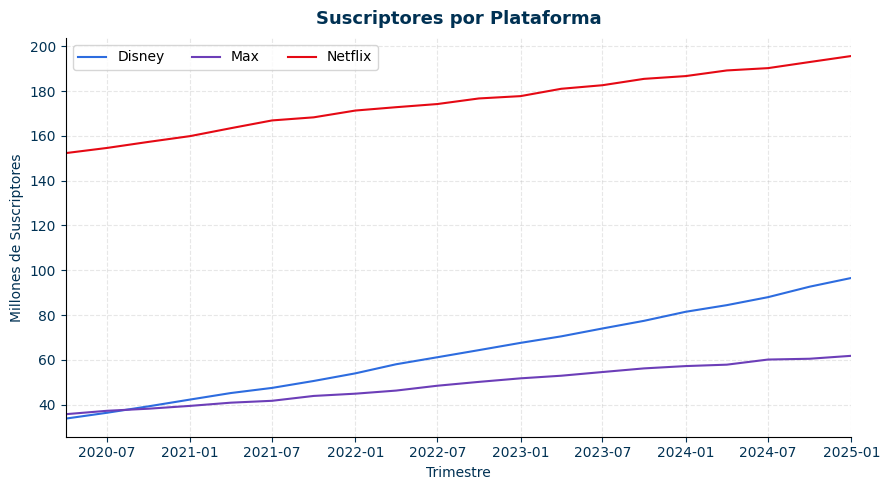

In [92]:
# C) Gráficos principales
# Suscriptores por plataforma
plot_metric(df_vis, "subs_end_millions", "Suscriptores por Plataforma", "Millones de Suscriptores")
savefig("01_subscriptores_por_plataforma.png"); plt.show(); plt.close()

[fig] outputs_project/02_altas_trimestrales_por_plataforma.png


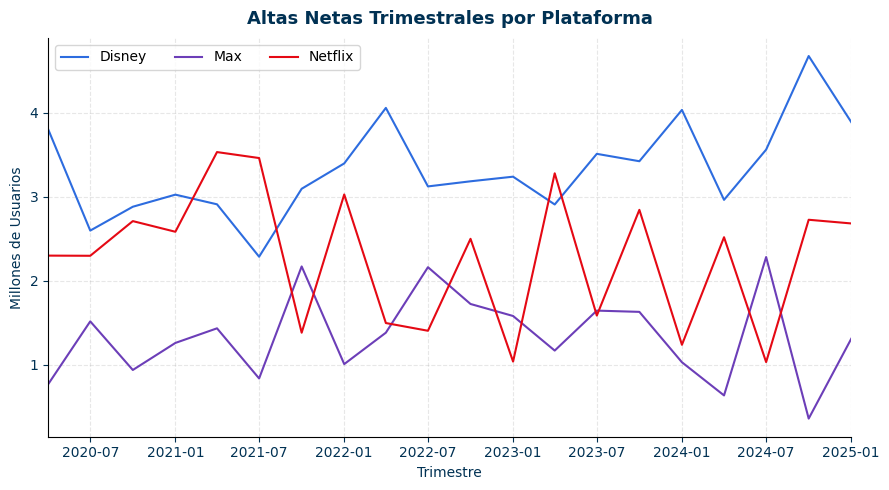

In [93]:
# Altas netas trimestrales por plataforma
plot_metric(df_vis, "net_adds_millions", "Altas Netas Trimestrales por Plataforma", "Millones de Usuarios")
savefig("02_altas_trimestrales_por_plataforma.png"); plt.show(); plt.close()

[fig] outputs_project/03_ingresos_trimestrales_por_plataforma.png


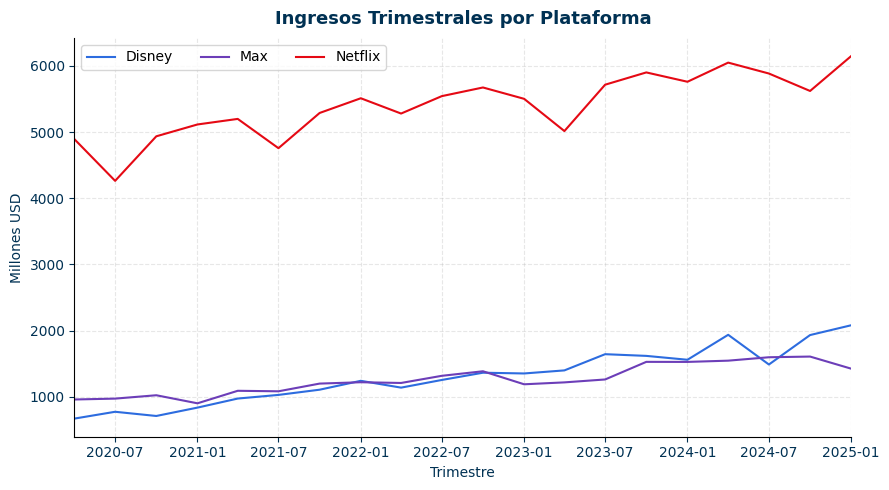

In [94]:
# Ingresos trimestrales por plataforma
plot_metric(df_vis, "revenue_millions", "Ingresos Trimestrales por Plataforma", "Millones USD")
savefig("03_ingresos_trimestrales_por_plataforma.png"); plt.show(); plt.close()

[fig] outputs_project/04_arpu_mensual_por_plataforma.png


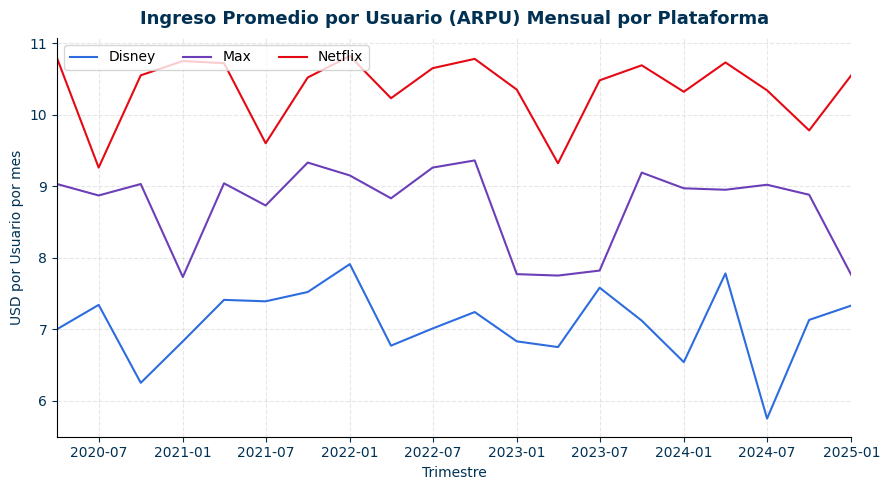

In [95]:
# ARPU Average Revenue Per User (ingreso promedio por usuario) mensual por plataforma
plot_metric(df_vis, "arpu", "Ingreso Promedio por Usuario (ARPU) Mensual por Plataforma", "USD por Usuario por mes")
savefig("04_arpu_mensual_por_plataforma.png"); plt.show(); plt.close()

[fig] outputs_project/05_inversion_trimestral_por_plataforma.png


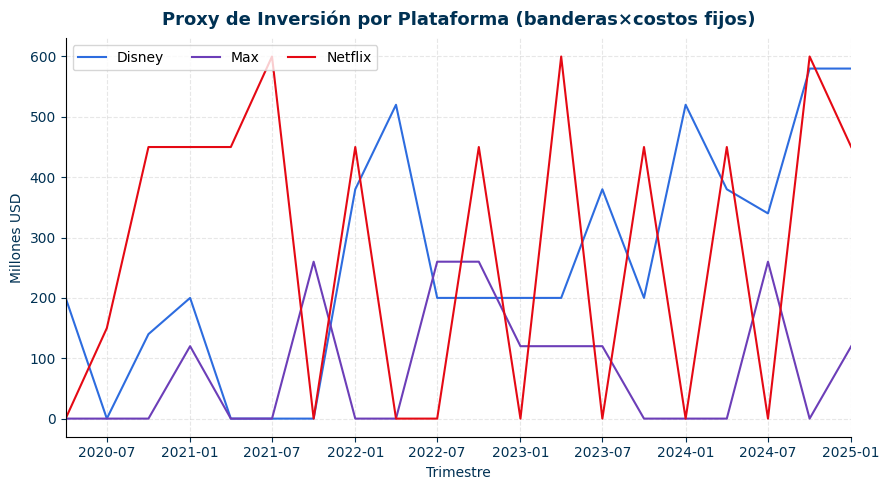

In [96]:
# D) Proxy de inversión basada en flags y costos supuestos
USE_INVESTMENT_PROXY = True

if USE_INVESTMENT_PROXY:
    # Costos fijos “tipo” por trimestre (millones USD) coherentes con el bloque de parámetros del juego
    COST_FIXED = {
        "Netflix": {"O": 450.0, "P": 150.0},
        "Disney":  {"O": 380.0, "P": 140.0, "B": 200.0},
        "Max":     {"O": 260.0, "P": 120.0},
    }
    # Proxy lineal: suma de costos activados por las banderas (pueden coexistir O y P en un trimestre)
    def investment_proxy(row):
        p = row["platform"]
        cf = COST_FIXED.get(p, {})
        val = 0.0
        val += cf.get("O", 0.0) * float(row.get("flag_O", 0))
        val += cf.get("P", 0.0) * float(row.get("flag_P", 0))
        val += cf.get("B", 0.0) * float(row.get("flag_B", 0))
        return val

    df_vis["invest_proxy_millions"] = df_vis.apply(investment_proxy, axis=1)
    plot_metric(df_vis, "invest_proxy_millions", "Proxy de Inversión por Plataforma (banderas×costos fijos)", "Millones USD")
    savefig("05_inversion_trimestral_por_plataforma.png"); plt.show(); plt.close()


In [97]:
# ---- E) Descriptivas para el paper ----
cols = ["subs_end_millions","net_adds_millions","arpu"]
if "revenue_millions" in df_vis.columns:
    cols.append("revenue_millions")
desc_by_platform = (df_vis.groupby("platform")[cols].agg(["mean","std","min","max"]).round(2))
print("\n=== Descriptivas por plataforma ===")
display(desc_by_platform)


=== Descriptivas por plataforma ===


subs_end_millions                        net_adds_millions        \
                      mean    std     min     max              mean   std   
platform                                                                    
Disney               63.27  19.48   33.80   96.56              3.33  0.56   
Max                  49.02   8.47   35.77   61.82              1.34  0.52   
Netflix             174.95  13.11  152.30  195.63              2.28  0.81   

                       arpu                    revenue_millions          \
           min   max   mean   std   min    max             mean     std   
platform                                                                  
Disney    2.29  4.68   7.07  0.52  5.75   7.91          1304.89  412.95   
Max       0.36  2.28   8.72  0.59  7.73   9.36          1262.45  222.22   
Netflix   1.03  3.53  10.36  0.49  9.26  10.82          5402.81  478.08   

                            
              min      max  
platform                    
Disney     669.94  2080.68  
Max        900.92  1607.32  
Netflix   4262.77  6149.18

In [98]:
# 1) ESPECIFICACIÓN EMPÍRICA (versión con fórmulas): evita dummies manuales y problemas de colinealidad

# Asegura que las flags (propias y rivales) sean numéricas; NaN→0 para no romper OLS
for c in ["flag_O","flag_P","flag_B","riv_flag_O","riv_flag_P","riv_flag_B"]:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

# Declara 'platform' como categórica; el baseline (referencia) lo define la fórmula (Netflix)
df["platform"] = df["platform"].astype("category")

# Calculo de OLS (Mínimos Cuadrados Ordinarios)
# Modelo 1: altas netas (millones) como función de estrategias propias, presión rival y FE de plataforma
m_net = smf.ols(
    'net_adds_millions ~ flag_O + flag_P + flag_B + riv_flag_O + riv_flag_P + riv_flag_B '
    '+ C(platform, Treatment("Netflix"))',
    data=df
).fit()

# Modelo 2: ARPU (USD/usuario/mes) con la misma especificación explicativa
m_arp = smf.ols(
    'arpu ~ flag_O + flag_P + flag_B + riv_flag_O + riv_flag_P + riv_flag_B '
    '+ C(platform, Treatment("Netflix"))',
    data=df
).fit()

# Resumen compacto de coeficientes (magnitud, error estándar, t, p, intervalos)
print("=== OLS net_adds (coeficientes) ===")
display(m_net.summary().tables[1])

print("\n=== OLS ARPU (coeficientes) ===")
display(m_arp.summary().tables[1])


=== OLS net_adds (coeficientes) ===


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.0212,0.116,17.373,0.000,1.788,2.255
"C(platform, Treatment(""Netflix""))[T.Disney]",0.7792,0.123,6.357,0.000,0.533,1.025
"C(platform, Treatment(""Netflix""))[T.Max]",-0.5229,0.098,-5.359,0.000,-0.719,-0.327
flag_O,0.9969,0.088,11.383,0.000,0.821,1.173
flag_P,0.3554,0.097,3.667,0.001,0.161,0.550
flag_B,0.8291,0.135,6.149,0.000,0.558,1.100
riv_flag_O,-0.2775,0.069,-4.048,0.000,-0.415,-0.140
riv_flag_P,-0.2190,0.075,-2.904,0.005,-0.370,-0.068
riv_flag_B,-0.2160,0.094,-2.306,0.025,-0.404,-0.028



=== OLS ARPU (coeficientes) ===


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,10.5113,0.040,264.523,0.000,10.432,10.591
"C(platform, Treatment(""Netflix""))[T.Disney]",-2.9902,0.042,-71.421,0.000,-3.074,-2.906
"C(platform, Treatment(""Netflix""))[T.Max]",-1.4985,0.033,-44.960,0.000,-1.565,-1.432
flag_O,0.2735,0.030,9.142,0.000,0.213,0.334
flag_P,-1.2306,0.033,-37.179,0.000,-1.297,-1.164
flag_B,-0.4670,0.046,-10.139,0.000,-0.559,-0.375
riv_flag_O,0.0248,0.023,1.058,0.295,-0.022,0.072
riv_flag_P,-0.1818,0.026,-7.058,0.000,-0.233,-0.130
riv_flag_B,0.0282,0.032,0.881,0.382,-0.036,0.092


In [99]:
# 2) PARÁMETROS DEL JUEGO
# Conjunto de jugadores (orden útil para construir perfiles y mejores respuestas)
PLAYERS = ["Netflix","Disney","Max"]
# Estrategias disponibles por jugador:
# - Netflix: O = “originales”, P = “precio/monetización”
# - Disney:  O, P y B = “bundle” (p.ej. Disney+ con Hulu/ESPN+)
# - Max:     O, P (no consideramos bundle aquí)
STRATS  = {"Netflix":["O","P"], "Disney":["O","P","B"], "Max":["O","P"]}

# Stock de referencia S0 (millones de suscriptores)
# Usamos el PROMEDIO histórico del inicio de trimestre por plataforma para suavizar ruido.
S0 = df.groupby("platform")["subs_start_millions"].mean().to_dict()

# Estructura de costos:
# COST_FIXED: costo FIJO por TRIMESTRE (en millones USD) asociado a la estrategia elegida por cada jugador.
#   - O suele ser más caro (producción de originales)
#   - P implica costes comerciales/tecnológicos (pricing/ads), típicamente menores que O
#   - B (solo Disney) tiene un costo intermedio (gestión de empaquetado y descuentos)
COST_FIXED = {
    "Netflix": {"O": 450.0, "P": 150.0},
    "Disney":  {"O": 380.0, "P": 140.0, "B": 200.0},
    "Max":     {"O": 260.0, "P": 120.0},
}
# Costo VARIABLE mensual por usuario (USD/usuario/mes):
# Aproxima gastos de distribución, CDN, pagos, soporte, etc.
CV_MONTHLY = 2.0
# Conversión de trimestre a meses:
# ARPU viene mensual; multiplicamos por 3 para llevar la contribución a base trimestral.
MONTHS_PER_Q = 3.0

In [100]:
# 3) PREDICCIÓN POR PERFIL
# Objetivo: dado un perfil de estrategias (NetFlix,Disney,Max), construir la fila de X que entiende
# el modelo por fórmulas, predecir (net_adds, arpu) por jugador y calcular su beneficio.
PLATFORM_CAT = CategoricalDtype(categories=["Netflix","Disney","Max"], ordered=False)

def _exog_row(player, profile):
    """Construye el exógeno para un jugador dado el perfil (DataFrame con 'platform')."""
    # Flags propias del jugador (O/P/B). Nota: B aplica efectivamente solo a Disney.
    fO = 1.0 if profile[player] == "O" else 0.0
    fP = 1.0 if profile[player] == "P" else 0.0
    fB = 1.0 if profile[player] == "B" else 0.0  # solo Disney usará B

    # Conteos de estrategias rivales en el mismo perfil (O, P, B)
    rO = sum(1 for j in PLAYERS if j != player and profile[j] == "O")
    rP = sum(1 for j in PLAYERS if j != player and profile[j] == "P")
    rB = sum(1 for j in PLAYERS if j != player and profile[j] == "B")

    # DataFrame con los nombres EXACTOS de la fórmula (incluye 'platform')
    X = pd.DataFrame([{
        "flag_O": fO,
        "flag_P": fP,
        "flag_B": fB,
        "riv_flag_O": float(rO),
        "riv_flag_P": float(rP),
        "riv_flag_B": float(rB),
        "platform": player, # requerido por C(platform, Treatment("Netflix"))
    }])

    # Asegura que 'platform' tenga el dtype categórico consistente con el modelo
    X["platform"] = X["platform"].astype(PLATFORM_CAT)
    return X

def predict_netadds_arpu(player, profile):
    """Predice (net_adds, arpu) para 'player' bajo 'profile' usando los modelos OLS."""
    X = _exog_row(player, profile)
    net  = float(m_net.predict(X).iloc[0])
    arpu = float(m_arp.predict(X).iloc[0])
    # salvaguardas razonables
    return max(-1.0, net), max(4.0, arpu)

def profit(player, profile):
    """Calcula el beneficio trimestral (millones USD) del jugador bajo el perfil."""
    net, arpu = predict_netadds_arpu(player, profile)
    S_end = S0.get(player, 10.0) + net
    contrib_per_user_Q = (arpu - CV_MONTHLY) * MONTHS_PER_Q
    contrib_millions   = S_end * max(0.0, contrib_per_user_Q)
    cf = COST_FIXED[player][profile[player]]
    return contrib_millions - cf


In [101]:
# 4) ENUMERAR LOS 12 PERFILES (2×3×2)
from itertools import product

# Genera todas las combinaciones puras de estrategias:
# N ∈ {O,P}, D ∈ {O,P,B}, M ∈ {O,P} → 2×3×2 = 12 perfiles
profiles = [{"Netflix":n, "Disney":d, "Max":m}
            for n in STRATS["Netflix"]
            for d in STRATS["Disney"]
            for m in STRATS["Max"]]

records = []
for prof in profiles:
    # Para cada perfil, calcula el pago (beneficio trimestral, en millones)
    rec = {"profile": prof}
    rec["Netflix_profit_m"] = profit("Netflix", prof)
    rec["Disney_profit_m"]  = profit("Disney",  prof)
    rec["Max_profit_m"]     = profit("Max",     prof)
    records.append(rec)

# Tabla final de pagos por perfil (cada fila = un perfil N,D,M)
payoff_df = pd.DataFrame(records)
print("\n=== Pagos (millones) por perfil 2×3×2 ===")
display(payoff_df)


=== Pagos (millones) por perfil 2×3×2 ===


,profile,Netflix_profit_m,Disney_profit_m,Max_profit_m
0,"{'Netflix': 'O', 'Disney': 'O', 'Max': 'O'}",4191.529452,727.778294,831.901556
1,"{'Netflix': 'O', 'Disney': 'O', 'Max': 'P'}",4084.520784,689.614826,736.801968
2,"{'Netflix': 'O', 'Disney': 'P', 'Max': 'O'}",4084.520784,674.321017,802.408497
3,"{'Netflix': 'O', 'Disney': 'P', 'Max': 'P'}",3977.439587,636.291027,707.442385
4,"{'Netflix': 'O', 'Disney': 'B', 'Max': 'O'}",4194.959411,764.852429,833.765782
5,"{'Netflix': 'O', 'Disney': 'B', 'Max': 'P'}",4087.913219,726.662962,738.381987
6,"{'Netflix': 'P', 'Disney': 'O', 'Max': 'O'}",3687.180980,689.614826,802.408497
7,"{'Netflix': 'P', 'Disney': 'O', 'Max': 'P'}",3580.305789,651.378829,707.442385
8,"{'Netflix': 'P', 'Disney': 'P', 'Max': 'O'}",3580.305789,636.291027,772.842907
9,"{'Netflix': 'P', 'Disney': 'P', 'Max': 'P'}",3473.358069,598.188506,678.010272


In [102]:
# 5) MEJORES RESPUESTAS Y NASH PUROS
def best_responses(df):
    # Diccionario: para cada jugador, el conjunto de índices de filas (perfiles) donde juega su mejor respuesta
    BR = {p:set() for p in PLAYERS}

    for p in PLAYERS:
        # Conjunto de “los otros” jugadores (para fijar sus estrategias)
        others = [q for q in PLAYERS if q!=p]
        groups = {}

        # Agrupa filas (perfiles) por las estrategias de los rivales s_{-p}
        # key = tupla ordenada con (jugador, estrategia) de los rivales
        for idx, row in df.iterrows():
            key = tuple((q, row["profile"][q]) for q in others)
            groups.setdefault(key, []).append(idx)

        # En cada grupo (rivales fijos), identifica las filas donde el pago de p es máximo
        col = f"{p}_profit_m"
        for _, idxs in groups.items():
            sub = df.loc[idxs]
            mx  = sub[col].max()
            # Añade todos los empates en el máximo (mejor respuesta puede no ser única)
            BR[p].update([i for i in idxs if abs(df.loc[i,col]-mx) < 1e-12])
    return BR

# Conjunto de índices que son mejor respuesta simultánea para TODOS los jugadores → Nash puro
BR = best_responses(payoff_df)
nash_idx = set.intersection(*BR.values())

# Tabla con los perfiles de equilibrio de Nash puro (si existen)
nash_df  = payoff_df.loc[sorted(nash_idx)].reset_index(drop=True)
print("\n=== Equilibrios de Nash PUROS ===")
display(nash_df if len(nash_df) else pd.DataFrame({"msg":["No se detectaron Nash puros con estos supuestos/costos."]}))


=== Equilibrios de Nash PUROS ===


,profile,Netflix_profit_m,Disney_profit_m,Max_profit_m
0,"{'Netflix': 'O', 'Disney': 'B', 'Max': 'O'}",4194.959411,764.852429,833.765782


In [103]:
# 6) PARETO-EFICIENCIA
def pareto_front(df):
    # Matriz de pagos (N, D, M) para cada perfil (filas)
    vals = df[["Netflix_profit_m","Disney_profit_m","Max_profit_m"]].values
    efficient = []

    # Revisa, para cada perfil i, si existe algún perfil j que lo domine
    for i in range(len(vals)):
        v = vals[i]; dominated = False
        for j in range(len(vals)):
            if j==i: continue
            w = vals[j]
            # Dominancia de Pareto: w es >= en todos y > en alguno → i está dominado
            if np.all(w >= v) and np.any(w > v):
                dominated = True; break
        # Si no fue dominado por ninguno, es Pareto-eficiente (no dominado)
        if not dominated:
            efficient.append(i)

    # Devuelve solo los perfiles no dominados (frente de Pareto)
    return df.iloc[efficient].reset_index(drop=True)

pareto_df = pareto_front(payoff_df)
print("\n=== Perfiles Pareto-eficientes ===")
display(pareto_df)


=== Perfiles Pareto-eficientes ===


,profile,Netflix_profit_m,Disney_profit_m,Max_profit_m
0,"{'Netflix': 'O', 'Disney': 'B', 'Max': 'O'}",4194.959411,764.852429,833.765782


In [104]:
# 7) REBANADAS (FIJANDO MAX)
def show_slices(df, fixed_player="Max", rows_player="Netflix", cols_player="Disney"):
    # Recorre cada valor posible de la estrategia del jugador fijado (p.ej., Max ∈ {O,P})
    for val in STRATS[fixed_player]:
        print(f"\n=== {fixed_player}: {val} ===")

        # Encabezado de la tabla: columnas son las estrategias del jugador en columnas (Disney)
        header = [""] + [f"{cols_player}:{c}" for c in STRATS[cols_player]]
        print("{:<14} | {:<22} | {:<22} | {:<22}".format(*header))
        print("-"*88)

        # Filas: estrategias del jugador en filas (Netflix)
        for r in STRATS[rows_player]:
            cells = []
            # Para cada combinación (fila r, columna c), busca el perfil correspondiente en df
            for c in STRATS[cols_player]:
                mask = df["profile"].apply(lambda d: d[fixed_player]==val and d[rows_player]==r and d[cols_player]==c)
                sub = df[mask]
                if len(sub)==1:
                    # Extrae y formatea los pagos (N, D, M) de esa celda
                    n = sub["Netflix_profit_m"].iloc[0]
                    d = sub["Disney_profit_m"].iloc[0]
                    m = sub["Max_profit_m"].iloc[0]
                    cells.append(f"({n:.1f}, {d:.1f}, {m:.1f})")
                else:
                    # Si no hay exactamente un perfil (no debería pasar), deja un guion
                    cells.append("—")

            # Imprime la fila completa para la estrategia r del jugador en filas (Netflix)
            print("{:<14} | {:<22} | {:<22} | {:<22}".format(f"{rows_player}:{r}", *cells))

# Visualiza las dos rebanadas 2×3 fijando Max (O y P);
# filas = estrategias de Netflix, columnas = estrategias de Disney.
show_slices(payoff_df, fixed_player="Max", rows_player="Netflix", cols_player="Disney")


=== Max: O ===
               | Disney:O               | Disney:P               | Disney:B              
----------------------------------------------------------------------------------------
Netflix:O      | (4191.5, 727.8, 831.9) | (4084.5, 674.3, 802.4) | (4195.0, 764.9, 833.8)
Netflix:P      | (3687.2, 689.6, 802.4) | (3580.3, 636.3, 772.8) | (3690.3, 726.7, 804.2)

=== Max: P ===
               | Disney:O               | Disney:P               | Disney:B              
----------------------------------------------------------------------------------------
Netflix:O      | (4084.5, 689.6, 736.8) | (3977.4, 636.3, 707.4) | (4087.9, 726.7, 738.4)
Netflix:P      | (3580.3, 651.4, 707.4) | (3473.4, 598.2, 678.0) | (3583.4, 688.4, 709.0)


In [106]:
# 8) EXPORTS ÚTILES (para el paper)
out_dir = Path(OUT)
payoff_df.to_csv(out_dir/"payoffs_2x3x2.csv", index=False)
if len(nash_df):
    nash_df.to_csv(out_dir/"nash_puros.csv", index=False)
pareto_df.to_csv(out_dir/"pareto_front.csv", index=False)
print("\nGuardado en /content: payoffs_2x3x2.csv, nash_puros.csv (si hay), pareto_front.csv")



Guardado en /content: payoffs_2x3x2.csv, nash_puros.csv (si hay), pareto_front.csv
